# Skin Cancer Detection

In this notebook we are going to try finding out if a mole can be considered skin cancer or not.

To do this we are using the HAM 10000 dataset.
The dataset can be downloaded from https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

In [1]:
import torch as t
import torch.nn as nn
import torchvision.transforms.functional as F

import pandas as pd
import numpy as np
import random

device = 'cuda' if t.cuda.is_available() else 'cpu'
print(f"using device: {device}")

# Reproducibility -> Also ensures same train / validation / test split every time
t.manual_seed(42)
random.seed(42)
np.random.seed(42)

t.cuda.empty_cache()

using device: cuda


## Utility function to display images

Taken from pytorch official torchvision docs

In [12]:
import matplotlib.pyplot as plt

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img, mode='RGB')
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Target Classes

As a memo, please recall that the target values are gathered in the column called 'dx' and they can have the following values:

- 'nv' = Melanocytic nevi               (Not Cancerous)
- 'mel' = Melanoma                      (Cancerous)
- 'bkl' = Benign keratosis-like lesions (Not Cancerous)
- 'bcc' = Basal cell carcinoma          (Cancerous)
- 'akiec' = Actinic keratoses           (Pre-Cancerous)
- 'vasc' = Vascular lesions             (Not Cancerous)
- 'df' = Dermatofibroma                 (Not Cancerous)



In [5]:
from sklearn.preprocessing import LabelEncoder
from torchvision.io import decode_image
import torchvision as tv
import os

class HAM10000Dataset(t.utils.data.Dataset):
    def __init__(self, data_path, max_attempts = 100):
        self.data_path = data_path
        self.df = pd.read_csv(data_path + '/HAM10000_metadata.csv')
        self.label_encoder = LabelEncoder()
        encoded_targets = self.label_encoder.fit_transform(self.df['dx'])
        self.df['dx_numeric'] = encoded_targets.tolist()
        self.image_transformer = tv.transforms.Compose([
            tv.transforms.RandomRotation(10),
            tv.transforms.RandomHorizontalFlip(),
            tv.transforms.RandomVerticalFlip(),
            tv.transforms.Resize((640, 480), antialias=True),
        ])
        self.max_attempts = max_attempts
    
    def __len__(self):
        E, _ = self.df.shape
        return E

    def get_diagnosis_from_label(self, labels):
        return self.label_encoder.inverse_transform(labels)
    
    def __getitem__(self, index):
        attempts = 0
        while attempts < self.max_attempts:
            try:
                target = self.df['dx_numeric'].iloc[index]
                filename = '/HAM10000_images/' + self.df['image_id'].iloc[index] + '.jpg'
                a = os.path.expanduser(self.data_path)
                image = decode_image(a + filename)
                image = self.image_transformer(image)
                return image, target
            except (FileNotFoundError):
                print(f'Error opening the image at path {a + filename}')
                attempts += 1
                index = random.randint(0, len(self) - 1)
        raise Exception(f'Critical Error: Cannot load Dataset')

data_destination_path = '~/Documents/github/MachineLearning/Projects/SkinCancerDetection/data'
dataset = HAM10000Dataset(data_destination_path)
spy = dataset.df

Image #1: torch.Size([3, 640, 480]), diagnosis: ['bkl']
Image #2: torch.Size([3, 640, 480]), diagnosis: ['bkl']


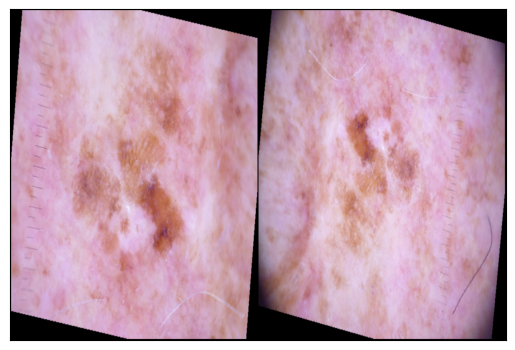

In [15]:
from torchvision.utils import make_grid

image_1, target_1 = dataset[0]
image_2, target_2 = dataset[1]

grid = make_grid([image_1, image_2])
show(grid)
print(f'Image #1: {image_1.shape}, diagnosis: {dataset.get_diagnosis_from_label([target_1])}')
print(f'Image #2: {image_2.shape}, diagnosis: {dataset.get_diagnosis_from_label([target_2])}')

In [16]:
from torch.utils.data import random_split, DataLoader

train_dataset, test_dataset, validation_dataset = random_split(dataset, [0.7, 0.29, 0.01])

batch_size = 3
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)

print(len(train_dataloader))
print(len(test_dataloader))
print(len(validation_dataloader))

2337
968
34


# The model

In computer vision it is normally a good idea to choose a **backbone** first rather than deciding on a whole new neural architecture.
This is because a **backbone** already takes care of some important aspects that make training possible, fast and overall better.
Besides, these models usually can found online with their pretrained weights that therefore really speed up the process.

Usually **backbones** ensure:

- Stable training 
- Shift invariance
- Locality (Motivation behing CNNs)
- Other desirable features that depend on the model design (fast attention for transformers)

## Efficient Net V2

For our **backbone** we opted to go for Efficient Net V2. As the name implies, the network is designed to be efficient (should be around 20M params for the small version) and after a quick search online I realized that it is the one that should achieve the best results in classification tasks.

In [17]:
from torchvision.models import efficientnet_v2_l, efficientnet_v2_m, efficientnet_v2_s

class SkinCancerClassifier(nn.Module):
    def __init__(self, hidden_size, out_classes, device = "cpu"):
        super().__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.backbone = efficientnet_v2_m(weights = 'DEFAULT').to(device)
        self.linears = nn.Sequential(
            nn.Linear(1000, hidden_size // 2), # 1000 is the output of the backbone since it was trained on a 1000 class dataset
            nn.Linear(hidden_size // 2, hidden_size),
            nn.Linear(hidden_size, out_classes),
            nn.Softmax(-1),
        ).to(device)

    def forward(self, image):
        image = image.to(self.device).float()
        image = self.backbone(image)
        image = self.linears(image)
        return image

    def size(self):
        def human_format(num):
            magnitude = 0
            while abs(num) >= 1000:
                magnitude += 1
                num /= 1000.0
            # add more suffixes if you need them
            return "%.2f%s" % (num, ["", "K", "M", "G", "T", "P"][magnitude])

        return human_format(sum(p.numel() for p in self.parameters()))


model = SkinCancerClassifier(1024, 7, device=device)
print(model.size())

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /home/acacioli/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth


100%|██████████| 208M/208M [00:01<00:00, 109MB/s]  


55.18M


In [18]:
def run_step(model, loss_fn, input, target):
    target = target.to(device=device).long()
    
    x = model(input)

    loss = loss_fn(x, target)
    return loss, x

In [19]:
def get_weight_of_label(label):
    diagnosis = dataset.get_diagnosis_from_label([label])[0]
    d = {
        'akiec': 5,
        'mel': 10,
        'bcc': 10,
    }
    return d.get(diagnosis, 1)


In [20]:
weight = [get_weight_of_label(i) for i in range(7)]
weight = t.Tensor(weight).to(device) # Assigning higher importance to a Cancerous and pre-Cancerous example that was predicted wrong
print(weight)
loss_fn = t.nn.CrossEntropyLoss(weight=weight)
learning_rate = 0.000001
optimizer = t.optim.Adam(model.parameters(), learning_rate)
images, targets = next(iter(validation_dataloader))

loss, predictions = run_step(model, loss_fn, images, targets)
print(f'Example distribution on example 0: {predictions[0]}')
print(f'Actual target for value 0: {targets[0]}')
optimizer.zero_grad()
loss.backward()
grad_norm = 0.0
for param in model.parameters():
    if param.grad is not None:
        grad_norm += param.grad.norm(2).item() ** 2  # L2 norm for each parameter
grad_norm = grad_norm ** 0.5  # Square root to get the L2 norm

print("Gradient Norm:", grad_norm)
loss

tensor([ 5., 10.,  1.,  1., 10.,  1.,  1.], device='cuda:0')
Example distribution on example 0: tensor([0.1136, 0.1369, 0.1397, 0.1463, 0.1356, 0.1991, 0.1288],
       device='cuda:0', grad_fn=<SelectBackward0>)
Actual target for value 0: 5
Gradient Norm: 2.8151280178284357


tensor(1.9308, device='cuda:0', grad_fn=<NllLossBackward0>)

In [25]:
import os


def get_unique_experiment_name():
    return model.__class__.__name__ + "_" + model.size()


models_dir = "/home/acacioli/Documents/github/MachineLearning/Projects/SkinCancerDetection/models/"
checkpoints = os.listdir(models_dir)
unique_name = get_unique_experiment_name()
checkpoints = [
    f for f in checkpoints if f[: min(len(unique_name), len(f))] == unique_name
]
if len(checkpoints) == 0:
    print("Starting from fresh: no models to load")
    epoch = 0
else:
    checkpoints.sort(key=lambda x: int(x[x.index("-") + 1 : -3]), reverse=True)

    epoch = int(checkpoints[0][checkpoints[0].index("-") + 1 : -3])
    print(f"Loading from {models_dir + checkpoints[0]}")
    model.load_state_dict(t.load(models_dir + checkpoints[0], weights_only=True))
    print(f"Loaded epoch {epoch}")

Loading from /home/acacioli/Documents/github/MachineLearning/Projects/SkinCancerDetection/models/SkinCancerClassifier_55.18M_epoch-66.pt
Loaded epoch 66


# Training

We use wandb to plot the performance during the training.

In [16]:
# Use Wandb
import wandb

wandb.login()
wandb.init(
    project="Skin Cancer Detection - Efficient Net V2",
    config={
        "total_parameters": model.size(),
        "backbone_size": "m",
        "learning_rate": learning_rate,
        "emb_size": model.hidden_size,
        "dataset": "HAM10000Dataset",
        "batch_size": batch_size,
    },
)
wandb.watch(model, log='all', log_freq=1)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: andrea-cacioli (andrea-cacioli-education). Use `wandb login --relogin` to force relogin


In [29]:
from torcheval.metrics import MulticlassAccuracy, MulticlassAUROC, MulticlassRecall, MulticlassPrecision
from torchmetrics.classification import MulticlassConfusionMatrix
from tqdm import tqdm


def get_metrics(num_classes, dataloader, verbose = True):
    metrics =  {
        'accuracy': MulticlassAccuracy(num_classes=num_classes),
        'precision' : MulticlassPrecision(num_classes=num_classes),
        'recall': MulticlassRecall(num_classes=num_classes),
        'AUC': MulticlassAUROC(num_classes=num_classes),
        }
    all_logits = []
    all_targets = []
    all_losses = []
    confusion = MulticlassConfusionMatrix(num_classes=num_classes)
    with t.no_grad():
        model.eval()
        it = tqdm(dataloader) if verbose else dataloader
        for images, targets in it:
            loss, logits = run_step(model, loss_fn, images, targets)
            for _, metric in metrics.items():
                metric.update(logits, targets)
                confusion.update(logits.cpu(), targets.cpu())
                all_logits += logits.tolist()
                all_targets += targets.tolist()
                all_losses += [loss.item()]
    return all_logits, all_targets, all_losses, metrics, confusion

In [18]:
from tqdm import tqdm
from IPython.display import clear_output
import copy


EVAL_EVERY = 10 # Only running evaluation step every 10 training steps
epochs = epoch + 500 # Set this to the number of training epochs you want to perform

with t.no_grad(): # To initialize the eval loss before training
    model.eval()
    images, targets = next(iter(validation_dataloader))
    loss, _ = run_step(model, loss_fn, images, targets)
    loss = loss.item()
    best_eval_loss = loss
    best_epoch = -1
    model.train()


while epoch < epochs:
    i = 0
    for images, targets in tqdm(train_dataloader):
        #Training Step
        optimizer.zero_grad()
        loss, _ = run_step(model, loss_fn, images, targets)
        loss.backward()
        optimizer.step()

        wandb.log({"train_loss": loss.item()})


        if i == 0:
            #Validation Step
            print(f"Evaluating: Epoch {epoch}")
            all_logits, all_targets, all_losses, metrics, confusion = get_metrics(7, validation_dataloader, verbose = False)
            loss = sum(all_losses) / len(all_losses)
            metrics = {metric_name: metric.compute() for metric_name, metric in metrics.items()}
            wandb.log({"eval_loss": loss})
            wandb.log(metrics)
            if loss < best_eval_loss: # Getting the best model
                best_eval_loss = loss
                best_model = copy.deepcopy(model)
                best_epoch = epoch
            model.train()
            clear_output()

        i = (i + 1) % EVAL_EVERY

    
    clear_output()
    print(f"Current Best Epoch: {best_epoch}: Validation Loss: {best_eval_loss}")
    epoch += 1

print(f"Going back to epoch {best_epoch}: validation loss: {best_eval_loss}")
model = best_model
epoch = best_epoch
wandb.finish()

  2%|▏         | 55/2337 [01:10<48:41,  1.28s/it]  


KeyboardInterrupt: 

In [ ]:
t.save(
    model.state_dict(),
    f"/home/andreacacioli/Documents/github/MachineLearning/SkinCancerDetection/models/{get_unique_experiment_name()}_epoch-{epoch}.pt",
)

# Testing 

First of all let's see how accurate the model is.

In [30]:
all_logits, all_targets, all_losses, metrics, confusion = get_metrics(7, test_dataloader)


100%|██████████| 968/968 [00:31<00:00, 30.41it/s]


accuracy: 0.8419421315193176
precision: 0.8419421315193176
recall: 0.8419421315193176
AUC: 0.9144469499588013
Class 0: ['akiec']		Cancerous
Class 1: ['bcc']		Cancerous
Class 2: ['bkl']		Not Cancerous
Class 3: ['df']		Not Cancerous
Class 4: ['mel']		Cancerous
Class 5: ['nv']		Not Cancerous
Class 6: ['vasc']		Not Cancerous


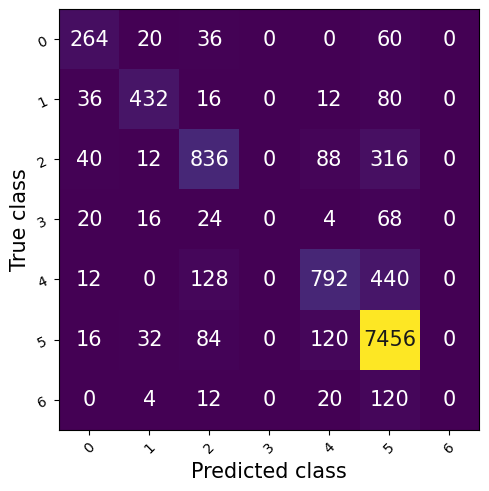

In [31]:
for metric_name, metric in metrics.items():
    print(f'{metric_name}: {metric.compute()}')

fig, ax = confusion.plot()
for i in range(7):
    label = dataset.get_diagnosis_from_label([i])
    print(f"Class {i}: {label}", end='\t\t')
    print('Cancerous' if get_weight_of_label(i) != 1 else 'Not Cancerous')

# Model does not predict some classes

Due to the weights (importance) of some classes, the model decides never to pick some of them.

In the general case this would not be ideal.
However, in this case this only means that should the model be unsure, it prefers going for a cancerous class instead of a non cancerous class (3 and 6 for example).

This can lead to more screanings procedure but less undetected cancerous cases.

# Cancerous class Accuracy

Since we do not want any cancerous case to go undetected, we are now going to measure how many cancerous examples are in any of the cancerous classes (even the wrong ones).

['not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'cancerous', 'not cancerous', 'not cancerous', 'cancerous', 'not cancerous', 'not cancerous', 'cancerous', 'not cancerous', 'not cancerous', 'cancerous', 'not cancerous', 'cancerous', 'not cancerous', 'cancerous', 'cancerous', 'not cancerous', 'cancerous', 'cancerous', 'not cancerous', 'cancerous', 'cancerous', 'not cancerous', 'cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cancerous', 'not cance

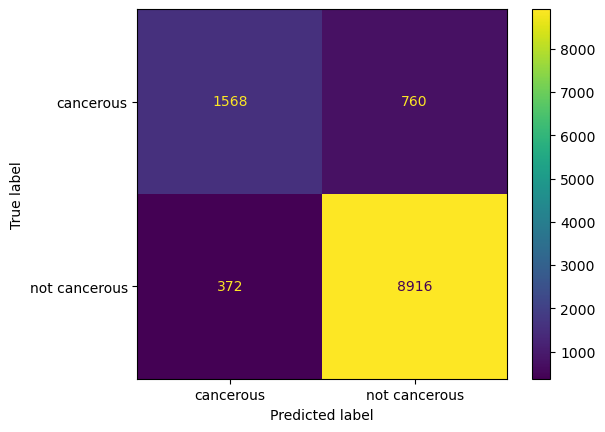

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

def is_cancerous(numeric_label):
    return get_weight_of_label(numeric_label) != 1

all_targets_binarized = ['cancerous' if is_cancerous(tar) else 'not cancerous' for tar in all_targets]
all_choices = [logits.index(max(logits)) for logits in all_logits]
all_choices_binarized = ['cancerous' if is_cancerous(choice) else 'not cancerous' for choice in all_choices]

print(all_targets_binarized)
print(all_choices)
print(all_choices_binarized)

ConfusionMatrixDisplay.from_predictions(all_targets_binarized, all_choices_binarized)

# Conclusions 

The model can correctly identify not cancerous images and cancerous images alike.
Moreover, it has a clear tendency (as expected) to predict cancerous classes even in not cancerous images (bottom left corner) ending up in people getting more screanings to find out they do not have cancer.

Out of all the cases the undetected cancerous examples are a tiny minority and we are going to count the percentage in the following cell:

In [34]:
total = len(all_targets_binarized)
count = 0
for target, prediction in zip(all_targets_binarized, all_choices_binarized):
    if target == 'cancerous' and prediction == 'not cancerous':
        count += 1

undetected_percentage = (count / total)  * 100

print(f'Undetected cancerous patients percentage: {undetected_percentage:.2f}%')

Undetected cancerous patients percentage: 6.54%


# Try it yourself

If you have got a mole and you would like to get a quick diagnosis you can use this notebook

In [55]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
import threading
import torchvision.transforms as transforms
import torch
from PIL import Image as PILImage

# =============================
# Widgets
# =============================

stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger',
    tooltip='Stop the camera',
    icon='square'
)

logits_output = widgets.Output()

# Display widgets
display(widgets.HBox([stopButton]))
display(logits_output)

# =============================
# Transforms
# =============================


# Preprocess transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 480)),
    transforms.ToTensor(),
])

def view(button):
    cap = cv2.VideoCapture(0)
    display_handle = display(None, display_id=True)

    with torch.no_grad():
        model.eval()

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.flip(frame, 1)

            # Display original frame
            _, jpeg = cv2.imencode('.jpeg', frame)
            display_image = Image(data=jpeg.tobytes())
            display_handle.update(display_image)

            # =============================
            # Transform and Prediction
            # =============================

            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            input_tensor = transform(rgb_frame).unsqueeze(0).to(device)

            logits = model(input_tensor)
            logits_np = logits.cpu().numpy().flatten()

            # =============================
            # Logits Output
            # =============================
            with logits_output:
                clear_output(wait=True)
                print("Logits:")
                print(np.round(logits_np, 3))  # rounded for readability


            # Stop condition
            if stopButton.value:
                cap.release()
                display_handle.update(None)
                break

# =============================
# Start Thread
# =============================

thread = threading.Thread(target=view, args=(stopButton,))
thread.start()


Output()

None

Logits:
[0.    0.    0.006 0.002 0.    0.989 0.002]
